## Importing libraries

* Valid_dice: ~0.56
* Train_dice: ~0.587
* Valid Loss: ~0.742 (bceDice)
* Train Loss: ~0.672

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
ENCODER = 'se_resnet50'
logdir = "./logs/segmentation_unet_se_resnet50_finetune_2"

In [2]:
import os
import cv2
import collections
import time 
import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import pytorch as AT

from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

import segmentation_models_pytorch as smp
device=torch.device('cuda')

lz4 not available, disabling compression. To install lz4, run `pip install lz4`.


## Helper functions and classes

In [3]:
def get_img(x, folder: str='train_images_525/train_images_525'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{img_paths}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (350, 525)):
    """
    Create mask based on df, image name and shape.
    """
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)
    df = df[df["im_id"] == image_name]
    for idx, im_name in enumerate(df["im_id"].values):
        for classidx, classid in enumerate(["Fish", "Flower", "Gravel", "Sugar"]):
            mask = cv2.imread("../../input/understanding-clouds-resized/train_masks_525/train_masks_525/" + classid + im_name)
            if mask is None:
                continue
            if mask[:,:,0].shape != (350,525):
                mask = cv2.resize(mask, (525,350))
            masks[:, :, classidx] = mask[:,:,0]
    masks = masks/255
    return masks


def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')


def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            
            
def visualize_with_raw(image, mask, original_image=None, original_mask=None, raw_image=None, raw_mak=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)


    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mak[:, :, i])
        ax[1, i + 1].set_title(f'Raw predicted mask {class_dict[i]}', fontsize=fontsize)
        
    ax[2, 0].imshow(image)
    ax[2, 0].set_title('Transformed image', fontsize=fontsize)


    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(f'Predicted mask with processing {class_dict[i]}', fontsize=fontsize)
            
            
def plot_with_augmentation(image, mask, augment):
    """
    Wrapper for `visualize` function.
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)
    
    
sigmoid = lambda x: 1 / (1 + np.exp(-x))


def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    # don't remember where I saw it
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


def get_training_augmentation():
    train_transform = [
        albu.Resize(320, 640),
        albu.HorizontalFlip(p=0.25),
        albu.VerticalFlip(p=0.25),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0)
#         albu.GridDistortion(p=0.5),
#         albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640)
    ]
    return albu.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

## Data overview

Let's have a look at the data first.

In [4]:
path = '../../input/understanding_cloud_organization'
img_paths = '../../input/understanding-clouds-resized'
os.listdir(path)

['train.csv', 'sample_submission.csv', 'train_images', 'test_images']

We have folders with train and test images, file with train image ids and masks and sample submission.

In [5]:
train = pd.read_csv(f'{path}/train.csv')
sub = pd.read_csv(f'{path}/sample_submission.csv')

In [6]:
train.head()

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...

In [7]:
n_train = len(os.listdir(f'{img_paths}/train_images_525/train_images_525'))
n_test = len(os.listdir(f'{img_paths}/test_images_525/test_images_525'))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

There are 5546 images in train dataset
There are 3698 images in test dataset


In [8]:
train['Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Flower    5546
Fish      5546
Sugar     5546
Gravel    5546
Name: Image_Label, dtype: int64

So we have ~5.5k images in train dataset and they can have up to 4 masks: Fish, Flower, Gravel and Sugar.

In [9]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Sugar     3751
Gravel    2939
Fish      2781
Flower    2365
Name: Image_Label, dtype: int64

In [10]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().value_counts()

2    2372
3    1560
1    1348
4     266
Name: Image_Label, dtype: int64

But there are a lot of empty masks. In fact only 266 images have all four masks. It is important to remember this.

In [11]:
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])


sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

Let's have a look at the images and the masks.

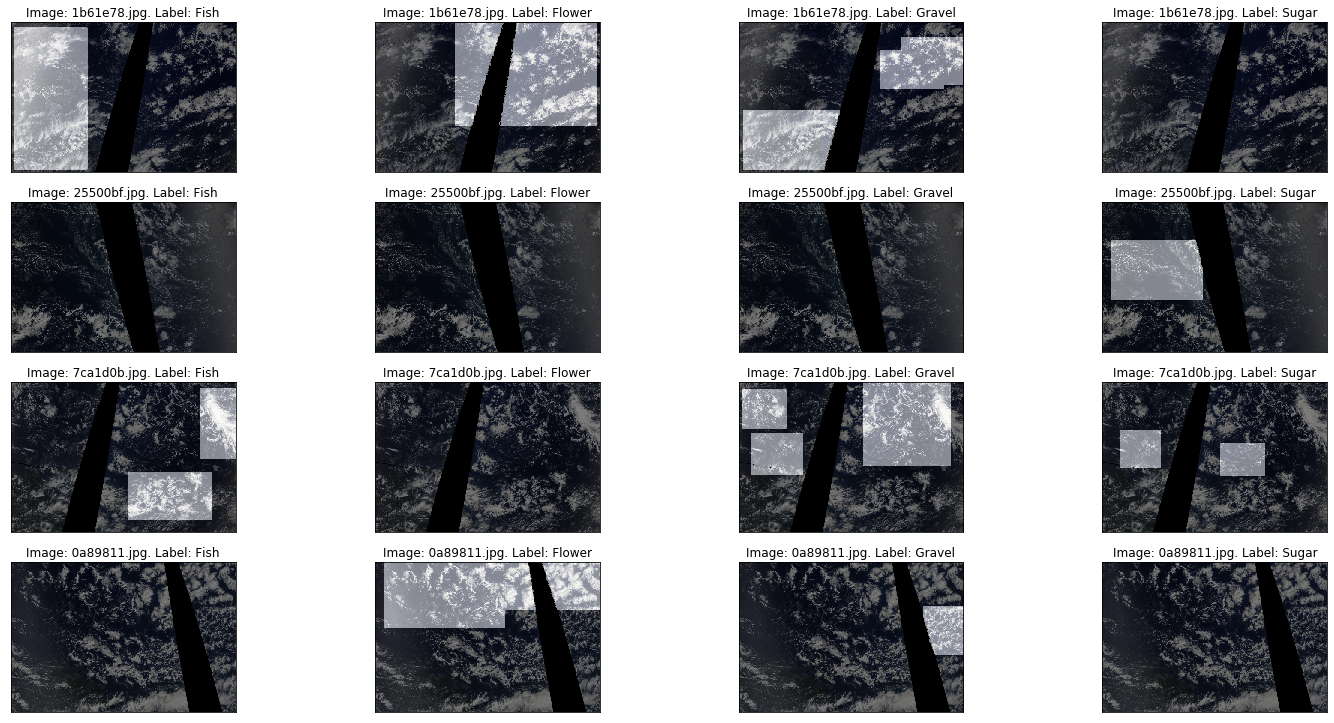

In [12]:
fig = plt.figure(figsize=(25, 16))
for j, im_id in enumerate(np.random.choice(train['im_id'].unique(), 4)):
    for i, (idx, row) in enumerate(train.loc[train['im_id'] == im_id].iterrows()):
        ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
        im = Image.open(f"{img_paths}/train_images_525/train_images_525/{row['Image_Label'].split('_')[0]}")
        plt.imshow(im)
        mask = cv2.imread(f"{img_paths}/train_masks_525/train_masks_525/{row['label']}{row['Image_Label'].split('_')[0]}", 0)
        if mask is None:
            mask = np.zeros((350, 525))
        plt.imshow(mask, alpha=0.5, cmap='gray')
        ax.set_title(f"Image: {row['Image_Label'].split('_')[0]}. Label: {row['label']}")

We can see that masks can overlap. Also we can see that clouds are really similar to fish, flower and so on. Another important point: masks are often quite big and can have seemingly empty areas.

## Preparing data for modelling

At first, let's create a list of unique image ids and the count of masks for images. This will allow us to make a stratified split based on this count.

In [13]:
from sklearn.model_selection import StratifiedKFold

id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().\
reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'}).sort_values(['count', 'img_id'])
k_fold = StratifiedKFold(n_splits=5, random_state=0)

idxs = list(k_fold.split(id_mask_count['img_id'], id_mask_count['count']))
train_ids, valid_ids = idxs[0]
test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

In [14]:
train_ids = id_mask_count['img_id'].iloc[train_ids].values
valid_ids = id_mask_count['img_id'].iloc[valid_ids].values

In [15]:
"""
array(['36087c7.jpg', '3614409.jpg', '361e863.jpg', '36a83e9.jpg',
       '36b798f.jpg', '36e8fb4.jpg', '36ffc1a.jpg', '371851d.jpg',
       '37254b5.jpg', '37b5e0c.jpg', '37bb4cd.jpg', '37d76b3.jpg',
       '37e8349.jpg', '3804b2b.jpg', '3851530.jpg'], dtype=object)
"""
train_ids[:15]

array(['36087c7.jpg', '3614409.jpg', '361e863.jpg', '36a83e9.jpg',
       '36b798f.jpg', '36e8fb4.jpg', '36ffc1a.jpg', '371851d.jpg',
       '37254b5.jpg', '37b5e0c.jpg', '37bb4cd.jpg', '37d76b3.jpg',
       '37e8349.jpg', '3804b2b.jpg', '3851530.jpg'], dtype=object)

## Exploring augmentations with albumentations

One of important things while working with images is choosing good augmentations. There are a lot of them, let's have a look at augmentations from albumentations!

In [16]:
train.head()

Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                NaN   
3   0011165.jpg_Sugar                                                NaN   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   

    label        im_id  
0    Fish  0011165.jpg  
1  Flower  0011165.jpg  
2  Gravel  0011165.jpg  
3   Sugar  0011165.jpg  
4    Fish  002be4f.jpg

In [17]:
image_name = '8242ba0.jpg'
image = get_img(image_name)
mask = make_mask(train, image_name)

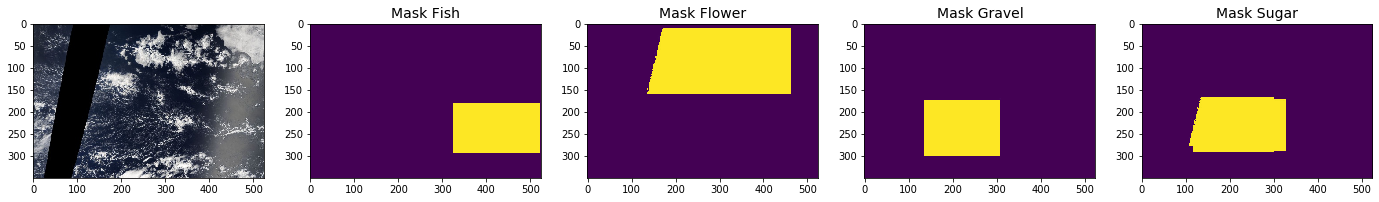

In [18]:
visualize(image, mask)

This is how original image and its masks look like. Let's try adding some augmentations

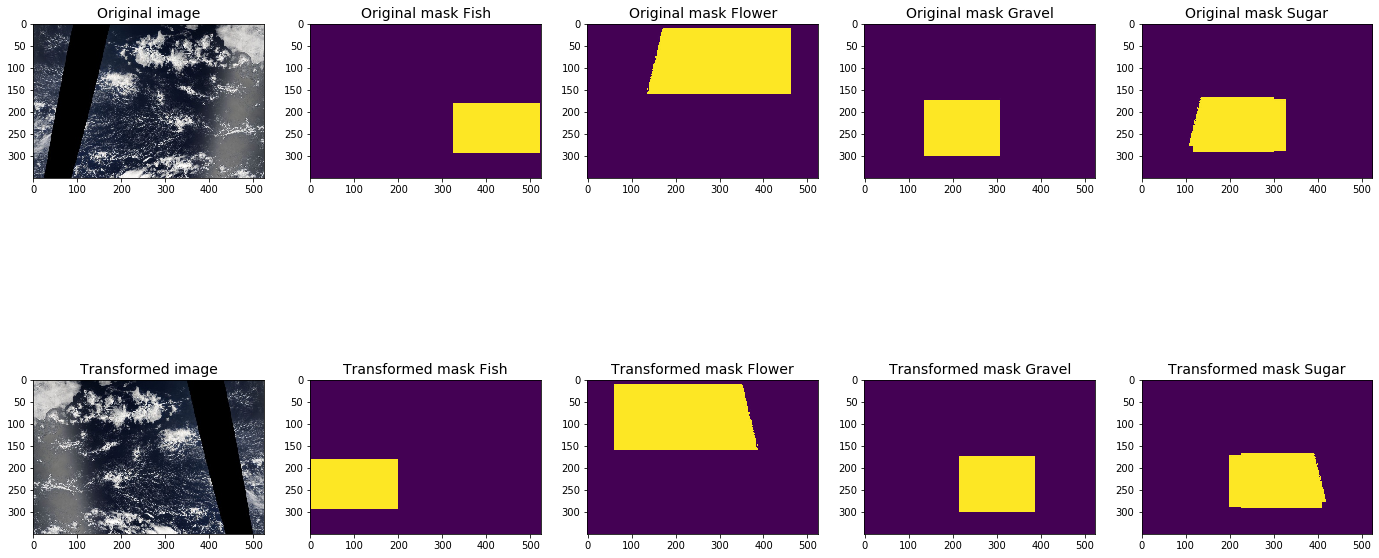

In [19]:
plot_with_augmentation(image, mask, albu.HorizontalFlip(p=1))

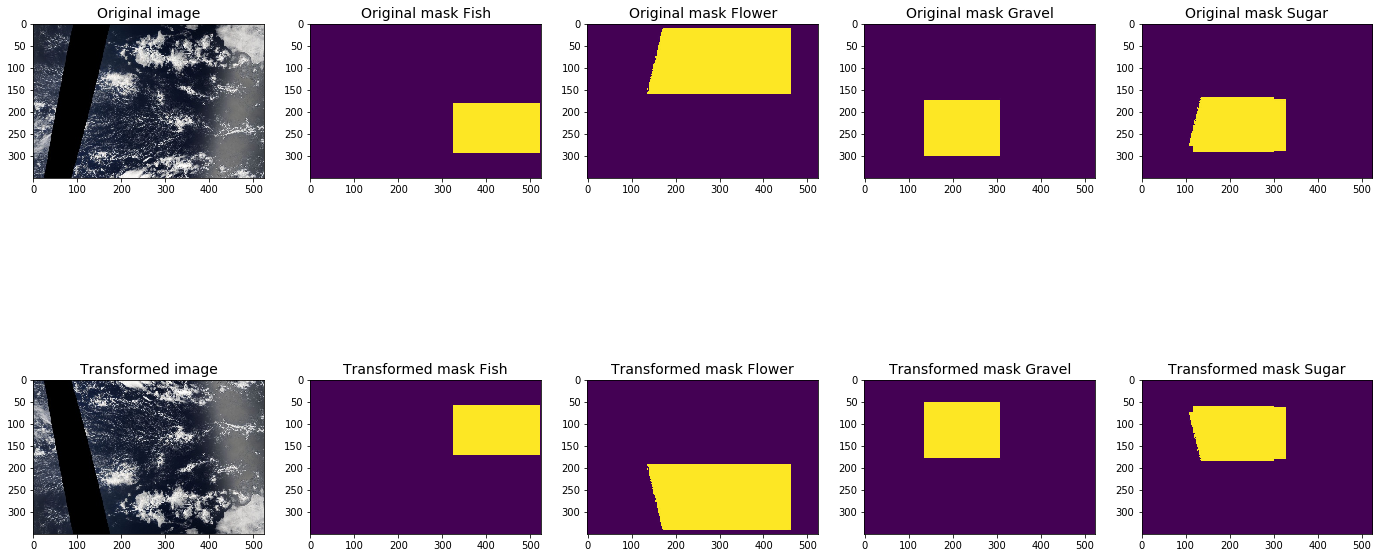

In [20]:
plot_with_augmentation(image, mask, albu.VerticalFlip(p=1))

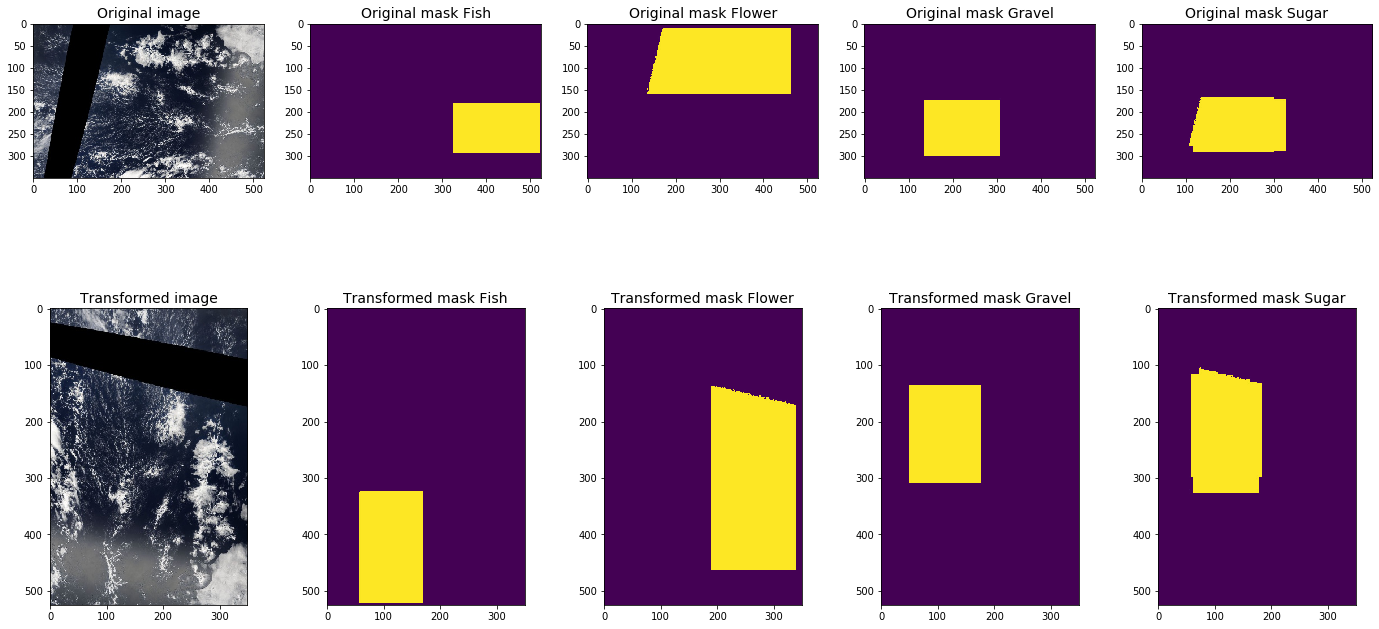

In [21]:
plot_with_augmentation(image, mask, albu.RandomRotate90(p=1))

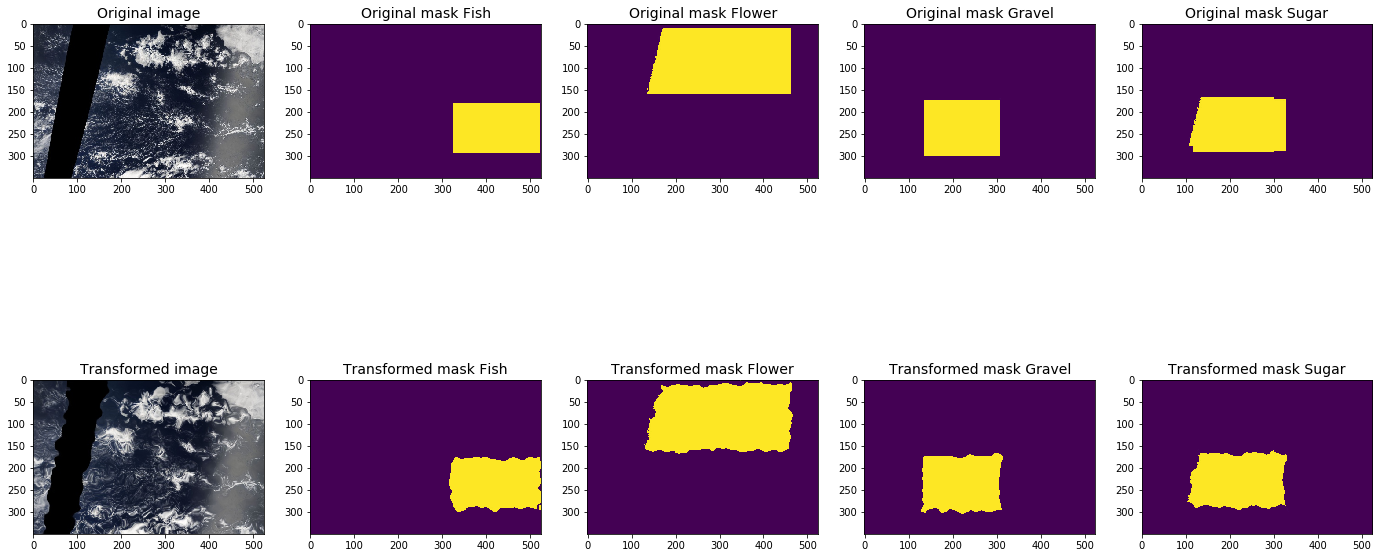

In [22]:
plot_with_augmentation(image, mask, albu.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03))

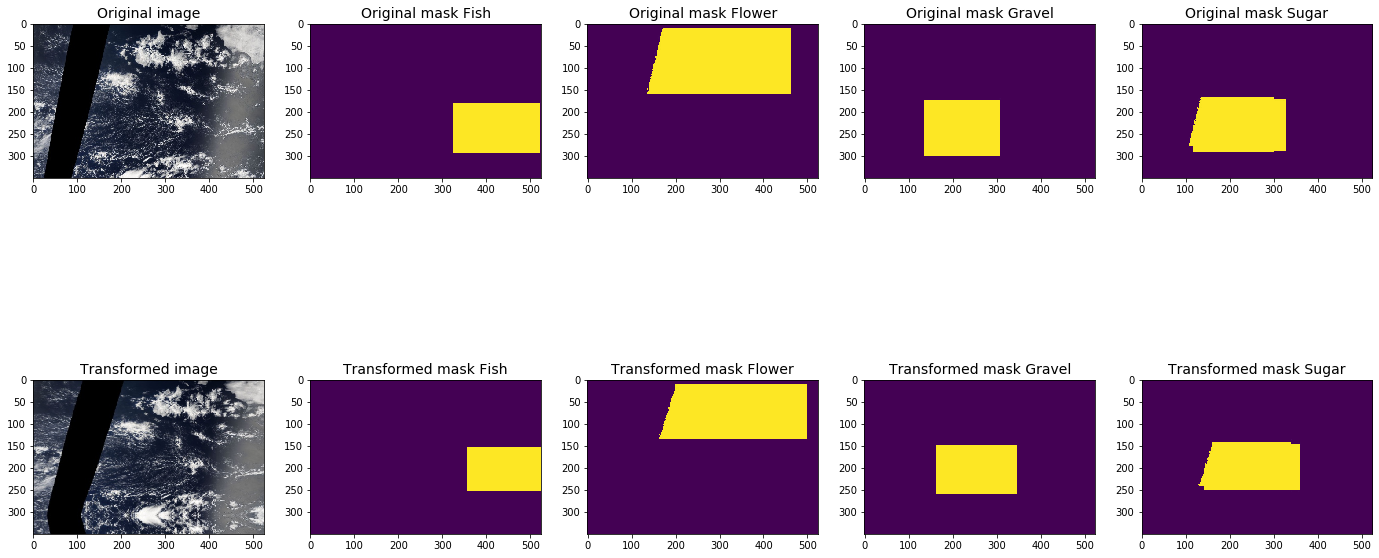

In [23]:
plot_with_augmentation(image, mask, albu.GridDistortion(p=1))

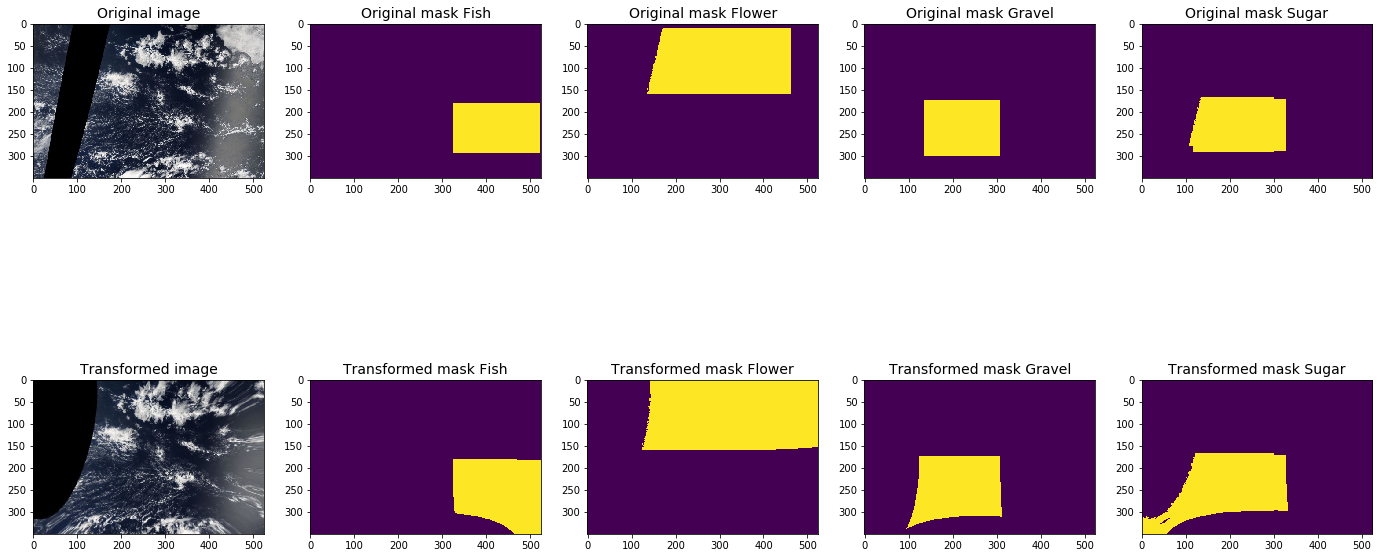

In [24]:
plot_with_augmentation(image, mask, albu.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5))

## Setting up data for training in Catalyst

In [25]:
class CloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame = None, datatype: str = 'train', img_ids: np.array = None,
                 transforms = albu.Compose([albu.HorizontalFlip(),AT.ToTensor()]),
                preprocessing=None):
        self.df = df
        if datatype != 'test':
            self.data_folder = f"{img_paths}/train_images_525/train_images_525"
        else:
            self.data_folder = f"{img_paths}/test_images_525/test_images_525"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

Now we define model and training parameters

In [26]:
ENCODER_WEIGHTS = 'imagenet'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [27]:
from torch.distributions import Bernoulli
from torch.utils.data.dataloader import default_collate

def mult(ratio, tensor):
    return torch.einsum('i,i...->i...', ratio, tensor)
    

def mixup(batch, mixup_ratio = 0.3, alpha=0.3):
    x,y = default_collate(batch)
    idx = torch.randperm(x.shape[0])
    x_swapped = x[idx].contiguous()
    y_swapped = y[idx].contiguous()
    
    mask = Bernoulli(torch.ones(x_swapped.shape[0]) * mixup_ratio).sample().bool()
    ratios =  torch.from_numpy(np.random.beta(alpha, alpha, x.shape[0]))[mask].float()
    x[mask] = mult(1 - ratios, x[mask]) + mult(ratios, x_swapped[mask])
    y[mask] = mult(1 - ratios, y[mask]) + mult(ratios, y_swapped[mask])

    return x, y

(array([287.,  73.,  39.,  63.,  51.,  42.,  41.,  53.,  72., 279.]),
 array([7.26103802e-09, 1.00000007e-01, 2.00000006e-01, 3.00000005e-01,
        4.00000004e-01, 5.00000004e-01, 6.00000003e-01, 7.00000002e-01,
        8.00000001e-01, 9.00000001e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

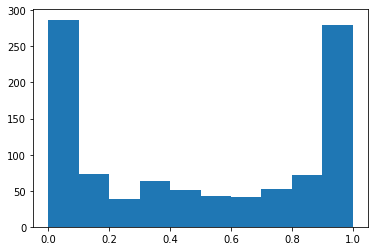

In [28]:
plt.hist(np.random.beta(0.3, 0.3, 1_000))

In [29]:
x = torch.randn((8, 3, 520, 640))
ratio = torch.randn((8,))
x.shape, ratio.shape, mult(ratio, x).shape

(torch.Size([8, 3, 520, 640]), torch.Size([8]), torch.Size([8, 3, 520, 640]))

In [30]:
num_workers = 1
bs = 6
train_dataset = CloudDataset(df=train, datatype='train', img_ids=train_ids, transforms = get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
valid_dataset = CloudDataset(df=train, datatype='valid', img_ids=valid_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, collate_fn=mixup)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

/home/max/PycharmProjects/cloud_segmentation/venv/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2567: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [31]:
for x, y in train_loader: break
x.shape, y.shape

(torch.Size([6, 3, 320, 640]), torch.Size([6, 4, 320, 640]))

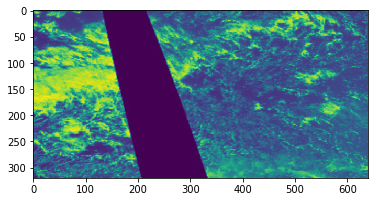

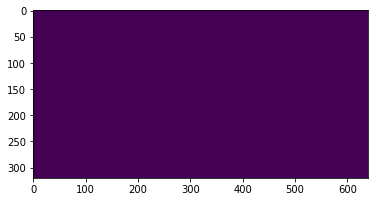

In [32]:
i = 1
j = 1
plt.imshow(x[i,j])
plt.show()
plt.imshow(y[i,j])
plt.show()

In [33]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [34]:
class WeightedLoss(nn.Module):
    
    def __init__(self, loss, weights):
        super().__init__()
        self.loss = loss
        self.weights = [weight/sum(weights) for weight in weights]
        
    def forward(self, input, target):
        # batch_size, 4, height, width
        loss = 0
        for i in range(target.shape[1]):
            loss += self.loss(input[:, i:i + 1], target[:, i: i + 1]) * self.weights[i]
        return loss

In [35]:
import torch.functional as F

class JaccardLoss(nn.Module):
    __name__ = 'jaccard_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - F.jaccard(y_pr, y_gt, eps=self.eps, threshold=None, activation=self.activation)

def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        beta (float): positive constant
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: F score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score

class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps
        self.beta = 1.

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=self.beta, eps=self.eps, threshold=None, activation=self.activation)


class BCEJaccardLoss(JaccardLoss):
    __name__ = 'bce_jaccard_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__(eps, activation)
        self.bce = nn.BCEWithLogitsLoss(reduction='mean')

    def forward(self, y_pr, y_gt):
        jaccard = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return jaccard + bce


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__(eps, activation)
        self.bce = nn.BCEWithLogitsLoss(reduction='mean')

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return dice + bce

In [36]:
from catalyst.dl.callbacks import OptimizerCallback, CriterionCallback

In [37]:
def parallelize(model):
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    return model

In [38]:
num_epochs = 25

# model, criterion, optimizer
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 0.5e-3}, 
    {'params': model.encoder.parameters(), 'lr': 0.5e-4},  
])
model.cuda()
model.load_state_dict(torch.load("./logs/segmentation_unet_se_resnet50/checkpoints/best.pth")['model_state_dict'])

<All keys matched successfully>

In [39]:
optimizer.load_state_dict(torch.load(os.path.join("./logs/segmentation_unet_se_resnet50",'optimizer.pkl')))

In [40]:
model = parallelize(model)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2)
# criterion = MixedLoss(10.0, 2.0)
#criterion = WeightedLoss(nn.BCEWithLogitsLoss(reduction='mean'), (1, 1, 1, 1))
criterion = WeightedLoss(smp.utils.losses.BCEDiceLoss(eps=1.), (3, 1, 3, 1))

runner = SupervisedRunner()

Let's use 2 GPUs!


## Model training

In [41]:
import random

import torch
from tqdm import tqdm
import time
import os
import numpy as np


def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    


In [42]:
class DicePerClass(DiceCallback):
    
    def __init__(self,
                 i: int = 0,
                 input_key: str = "targets",
                 output_key: str = "logits",
                 prefix: str = "dice",
                 eps: float = 1e-7,
                 threshold: float = None,
                 activation: str = "Sigmoid"):
        prefix = prefix + '_' + str(i)
        super().__init__(input_key,
                         output_key,
                         prefix,
                         eps,
                         threshold,
                         activation)
        self.i = i
    
    def on_batch_end(self, state):
        outputs = state.output[self.output_key][:, self.i: self.i+1]
        targets = state.input[self.input_key][:, self.i:self.i+1]
        metric = self.metric_fn(outputs, targets, **self.metric_params)
        state.metrics.add_batch_value(name=self.prefix, value=metric)

In [43]:
dice_callbacks = [DicePerClass(i=i) for i in range(4)] + [DiceCallback()]

In [ ]:
seed_everything(1)
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=dice_callbacks + [ EarlyStoppingCallback(patience=7, min_delta=0.001), 
               CriterionCallback(), OptimizerCallback(accumulation_steps=4)],
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

0/25 * Epoch (train): 100% 740/740 [04:07<00:00,  2.99it/s, _timers/_fps=240.091, dice=0.413, dice_0=0.357, dice_1=0.607, dice_2=0.000e+00, dice_3=0.000e+00, loss=1.157]
0/25 * Epoch (valid): 100% 186/186 [00:25<00:00,  7.40it/s, _timers/_fps=287.929, dice=0.479, dice_0=0.192, dice_1=0.078, dice_2=0.612, dice_3=0.759, loss=1.244]       
[2019-10-10 16:27:26,541] 
0/25 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=132.1843 | _timers/batch_time=0.0516 | _timers/data_time=0.0142 | _timers/model_time=0.0373 | dice=0.5111 | dice_0=0.4029 | dice_1=0.5355 | dice_2=0.4237 | dice_3=0.5103 | loss=0.8629
0/25 * Epoch 0 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=110.9813 | _timers/batch_time=0.0598 | _timers/data_time=0.0338 | _timers/model_time=0.0260 | dice=0.5334 | dice_0=0.4005 | dice_1=0.5584 | dice_2=0.4297 | dice_3=0.5442 | loss=0.8524
1/25 * Epoch (train): 100% 740/740 [04:04<00:00,  3.03it/s, _timers/_fps=233.864, dice=0.409, dice_0=0.228, 

9/25 * Epoch (train): 100% 740/740 [04:03<00:00,  3.04it/s, _timers/_fps=235.551, dice=0.472, dice_0=0.375, dice_1=0.000e+00, dice_2=0.000e+00, dice_3=0.838, loss=1.222]
9/25 * Epoch (valid): 100% 186/186 [00:25<00:00,  7.33it/s, _timers/_fps=290.541, dice=0.535, dice_0=0.517, dice_1=0.072, dice_2=0.575, dice_3=0.749, loss=0.999]       
[2019-10-10 17:08:40,362] 
9/25 * Epoch 9 (train): _base/lr=0.0013 | _base/momentum=0.9000 | _timers/_fps=133.8845 | _timers/batch_time=0.0456 | _timers/data_time=0.0138 | _timers/model_time=0.0317 | dice=0.5294 | dice_0=0.4302 | dice_1=0.5380 | dice_2=0.4455 | dice_3=0.5158 | loss=0.8281
9/25 * Epoch 9 (valid): _base/lr=0.0013 | _base/momentum=0.9000 | _timers/_fps=109.3729 | _timers/batch_time=0.0608 | _timers/data_time=0.0338 | _timers/model_time=0.0269 | dice=0.5488 | dice_0=0.4330 | dice_1=0.5716 | dice_2=0.4458 | dice_3=0.5514 | loss=0.8417
10/25 * Epoch (train): 100% 740/740 [04:07<00:00,  2.99it/s, _timers/_fps=235.061, dice=0.644, dice_0=0.108,

In [ ]:
utils.plot_metrics(
    logdir=logdir, 
    # specify which metrics we want to plot
    metrics=["loss", "dice", 'lr', '_base/lr']
)

In [ ]:
torch.save(optimizer.state_dict(), os.path.join(logdir,'optimizer.pkl'))